In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!curl -L https://anaconda.org/conda-forge/gudhi/3.1.1/download/linux-64/gudhi-3.1.1-py36hd3ef239_1.tar.bz2 | tar xj
!mv lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
import gudhi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3733    0  3733    0     0   6572      0 --:--:-- --:--:-- --:--:--  6572
100 3217k  100 3217k    0     0  1697k      0  0:00:01  0:00:01 --:--:-- 2574k


# Load Dataset

In [ ]:
!pip install kaggle
api_token = {"username":"ignasisanchez","key":"79ae11ad5532231e882297d5df83de82"}
import json
import zipfile
import os
!mkdir /root/.kaggle
!echo '{"username":"ignasisanchez","key":"79ae11ad5532231e882297d5df83de82"}' > /root/.kaggle/kaggle.json
!chmod 600 /content/.kaggle/kaggle.json
!kaggle config path -p /content
!kaggle datasets download -d shayanfazeli/heartbeat
!unzip heartbeat.zip

chmod: cannot access '/content/.kaggle/kaggle.json': No such file or directory
usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')
 74% 73.0M/98.8M [00:01<00:00, 37.7MB/s]
100% 98.8M/98.8M [00:01<00:00, 73.1MB/s]
Archive:  heartbeat.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


In [ ]:
data=pd.read_csv('mitbih_train.csv', header=None)

In [ ]:
X = data[data.columns.values[:-1]]
y = data[data.columns.values[-1]]

We start by plotting one ECG from each of the different class. We wanted to know if those signals had different shapes.

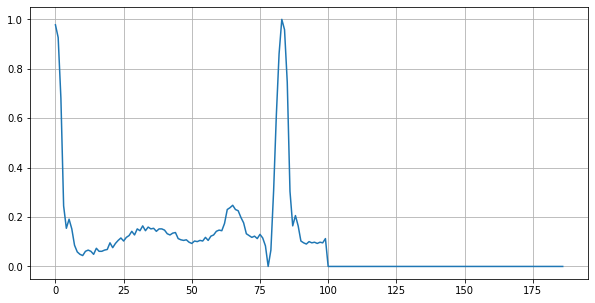

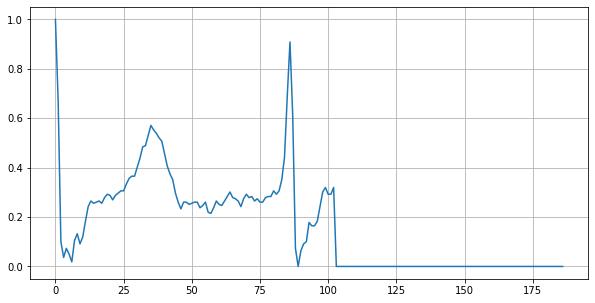

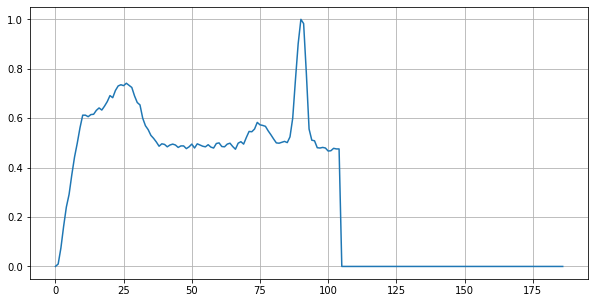

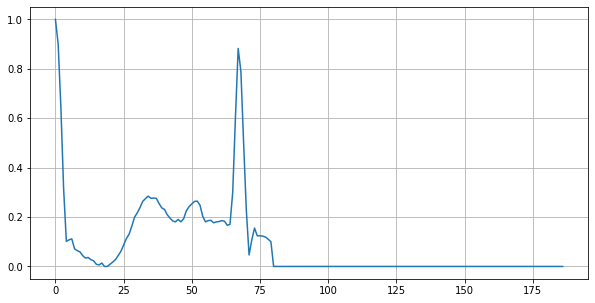

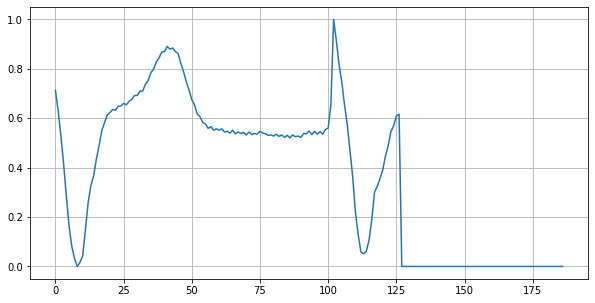

In [ ]:
X['class'] = y

class0 = X[X['class'] == 0.0].iloc[0]
class1 = X[X['class'] == 1.0].iloc[0]
class2 = X[X['class'] == 2.0].iloc[0]
class3 = X[X['class'] == 3.0].iloc[0]
class4 = X[X['class'] == 4.0].iloc[0]

plt.figure(figsize=(10, 5))
plt.plot(np.array(class0)[:-1] , '-')
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(np.array(class1)[:-1] , '-')
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(np.array(class2)[:-1] , '-')
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(np.array(class3)[:-1] , '-')
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(np.array(class4)[:-1] , '-')
plt.grid()
plt.show()

# Functions

In [ ]:
def getPersistence(vec, num_points=100, clean=True):
  """
  This transforms the 1D time series vec into a persistence diagram.
  """
  simplex_up = gudhi.SimplexTree()
  simplex_dw = gudhi.SimplexTree()
  # Fullfill the simplexes
  for i in np.arange(len(vec)): 
    simplex_up.insert([i], filtration=vec[i])
    simplex_dw.insert([i], filtration=-vec[i])
  for i in np.arange(len(vec)-1): 
    simplex_up.insert([i, i+1], filtration=vec[i])
    simplex_dw.insert([i, i+1], filtration=-vec[i])
  # Initialize the filtrations
  simplex_up.initialize_filtration()
  simplex_dw.initialize_filtration()


  dig_up = simplex_up.persistence()
  dig_dw = simplex_dw.persistence()

  if clean:
    dig_up = np.asarray([[ele[1][0], ele[1][1]] for ele in dig_up if ele[1][1] < np.inf])
    dig_dw = np.asarray([[ele[1][0], ele[1][1]] for ele in dig_dw if ele[1][1] < np.inf])

  return dig_up, dig_dw, simplex_up, simplex_dw

In [ ]:
def to_betti(vec, num_points=100):
  """
  This transforms the 1D time series vec into a betti curve with 100 points.
  No down simplex
  """
  dig_up, dig_dw, simplex_up, simplex_dw = getPersistence(vec, num_points, clean=True)

  mnu, mxu = np.min(dig_up), np.max(dig_up)
  #mnd, mxd = np.min(dig_dw), np.max(dig_dw)

  v,w = np.zeros(num_points), np.zeros(num_points)

  def functionize(val, descriptor):
    def dirichlet(x):
      return 1 if (x > descriptor[0]) and (x < descriptor[1]) else 0

    return np.vectorize(dirichlet)(val)

  val_up = np.linspace(mnu, mxu, num=num_points)
  #val_dw = np.linspace(mnd, mxd, num=num_points)

  for ele in dig_up: v += functionize(val_up, ele)
  #for ele in dig_dw: w += functionize(val_dw, ele)

  #return np.hstack([v, w])
  return v

In [ ]:
# http://bertrand.michel.perso.math.cnrs.fr/Enseignements/TDA/Tuto-Part4.html
# http://bertrand.michel.perso.math.cnrs.fr/Enseignements/TDA/persistence_graphical_tools_Bertrand.py
def landscapes_approx(diag_dim,x_min,x_max,nb_steps,nb_landscapes):
  """
  Returns nb_landscapes. Same as gudhi implementation
  """
  landscape = np.zeros((nb_landscapes,nb_steps))
  step = (x_max - x_min) / nb_steps
  #Warning: naive and not the best way to proceed!!!!!
  for i in range(nb_steps):
    x = x_min + i * step
    event_list = []
    for pair in diag_dim:
      b = pair[0]
      d = pair[1]
      if (b <= x) and (x<= d):
        if x >= (d+b)/2. :
          event_list.append((d-x))
        else:
          event_list.append((x-b))
    event_list.sort(reverse=True)
    event_list = np.asarray(event_list)
    for j in range(nb_landscapes):
      if(j<len(event_list)):
        landscape[j,i]=event_list[j]
  return landscape

In [ ]:
def confidence_interval(mu, lambdas, alpha=0.05, B=2000):
  n = lambdas.shape[0]

  thetas = np.zeros(B)

  for j in tqdm(range(B)):
    zetas = np.random.normal(size=(1,n))
    thetas[j] = np.max(np.abs(np.dot(zetas, lambdas-mu))/np.sqrt(n))

  zz = np.linspace(thetas.min(), thetas.max(), num=1000)
  Z_alpha = np.zeros(1000)
  for i, z in enumerate(zz):
    Z_alpha[i] = np.sum(thetas<z)/B

  idx = np.argmin(Z_alpha<=alpha)
  Z_alpha = zz[idx]

  lower = mu - Z_alpha/np.sqrt(n)
  upper = mu + Z_alpha/np.sqrt(n)

  return lower, upper

# Persistence

## Persistence diagram

We compute the persistence Diagram and the Barcode representation of one sample of the dataset. Our goal here is to see what kind of data we have, and so to explore possible uses and representations of the same. We want to use Topological Data Analysis for this data-set, but first we need to familiarize ourself with such.

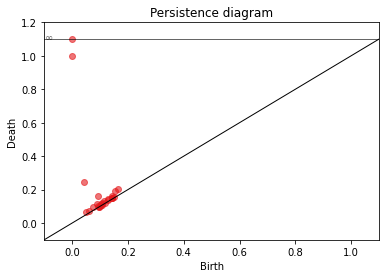

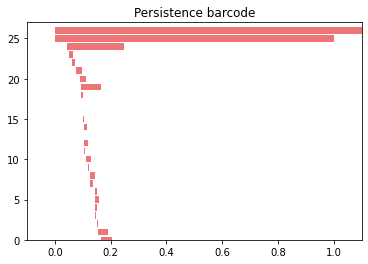

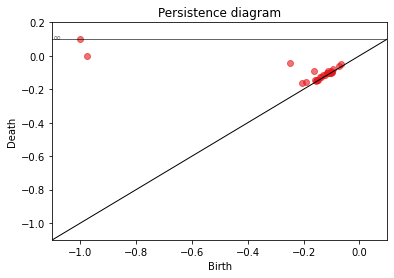

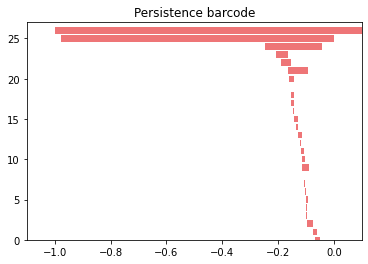

In [ ]:
vec = X.iloc[0].to_numpy()
# Defines the filtration
simplex_up = gudhi.SimplexTree()
simplex_dw = gudhi.SimplexTree()
# Fullfill the simplexes
for i in np.arange(len(vec)): 
    simplex_up.insert([i], filtration=vec[i])
    simplex_dw.insert([i], filtration=-vec[i])
for i in np.arange(len(vec)-1): 
    simplex_up.insert([i, i+1], filtration=vec[i])
    simplex_dw.insert([i, i+1], filtration=-vec[i])
# Initialize the filtrations
simplex_up.initialize_filtration()
simplex_dw.initialize_filtration()


dig_up = simplex_up.persistence()
dig_dw = simplex_dw.persistence()

gudhi.plot_persistence_diagram(dig_up)

gudhi.plot_persistence_barcode(dig_up)

gudhi.plot_persistence_diagram(dig_dw)

gudhi.plot_persistence_barcode(dig_dw)

plt.show()


## Betti Curves

Since we are comparing our work with the previously done, we cannot ignore that much of the previous work regarding TDA is done with betti curves. Betti curves are a vector-like data representation that counts how many bars in the barcode are active at a given time. 

This code has given pass to the function `to_betti` that we will use in other notebooks.

In [ ]:
dig_up = np.asarray([[ele[1][0], ele[1][1]] for ele in dig_up if ele[1][1] < np.inf])
dig_dw = np.asarray([[ele[1][0], ele[1][1]] for ele in dig_dw if ele[1][1] < np.inf])

In [ ]:
mnu, mxu = np.min(dig_up), np.max(dig_up)
mnd, mxd = np.min(dig_dw), np.max(dig_dw)

num_points=100
v,w = np.zeros(num_points), np.zeros(num_points)

In [ ]:
def functionize(val, descriptor):

    def dirichlet(x):
        return 1 if (x > descriptor[0]) and (x < descriptor[1]) else 0

    return np.vectorize(dirichlet)(val)

val_up = np.linspace(mnu, mxu, num=num_points)
val_dw = np.linspace(mnd, mxd, num=num_points)

for ele in dig_up: v += functionize(val_up, ele)
for ele in dig_dw: w += functionize(val_dw, ele)

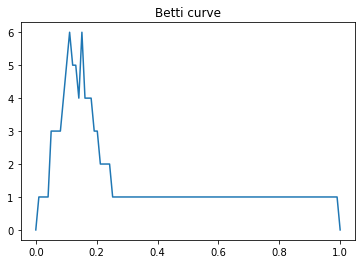

In [ ]:
plt.figure()
plt.plot(val_up, v)
plt.title("Betti curve")
plt.show()

## Clustering

### Barcodes

There are many possible ways of clustering our data with TDA representations. The first one would be to explore the barcodes. Barcodes have an associated distance, the bottleneck distance, that comes with some interesting stability results. Here, we compute the barcode representation for each of our samples and then perform a matrix distance between all samples, using the bottleneck distance.

In [ ]:
persistence = [getPersistence(X.iloc[i].to_numpy())[0] for i in tqdm(range(X.shape[0]))]

In [ ]:
n = 200
mask = []
for i in range(5):
    mask0 = np.where(y==i)[0]
    mask0 = np.random.choice(mask0, n, replace=False)
    mask += mask0.tolist()

pepe = [persistence[x] for x in mask]

dist_matrix = np.zeros((len(pepe), len(pepe)), np.float)
for i,p1 in enumerate(pepe):
    for j,p2 in enumerate(pepe):
        dist_matrix[i,j] = gudhi.bottleneck_distance(p1, p2, 0.1)

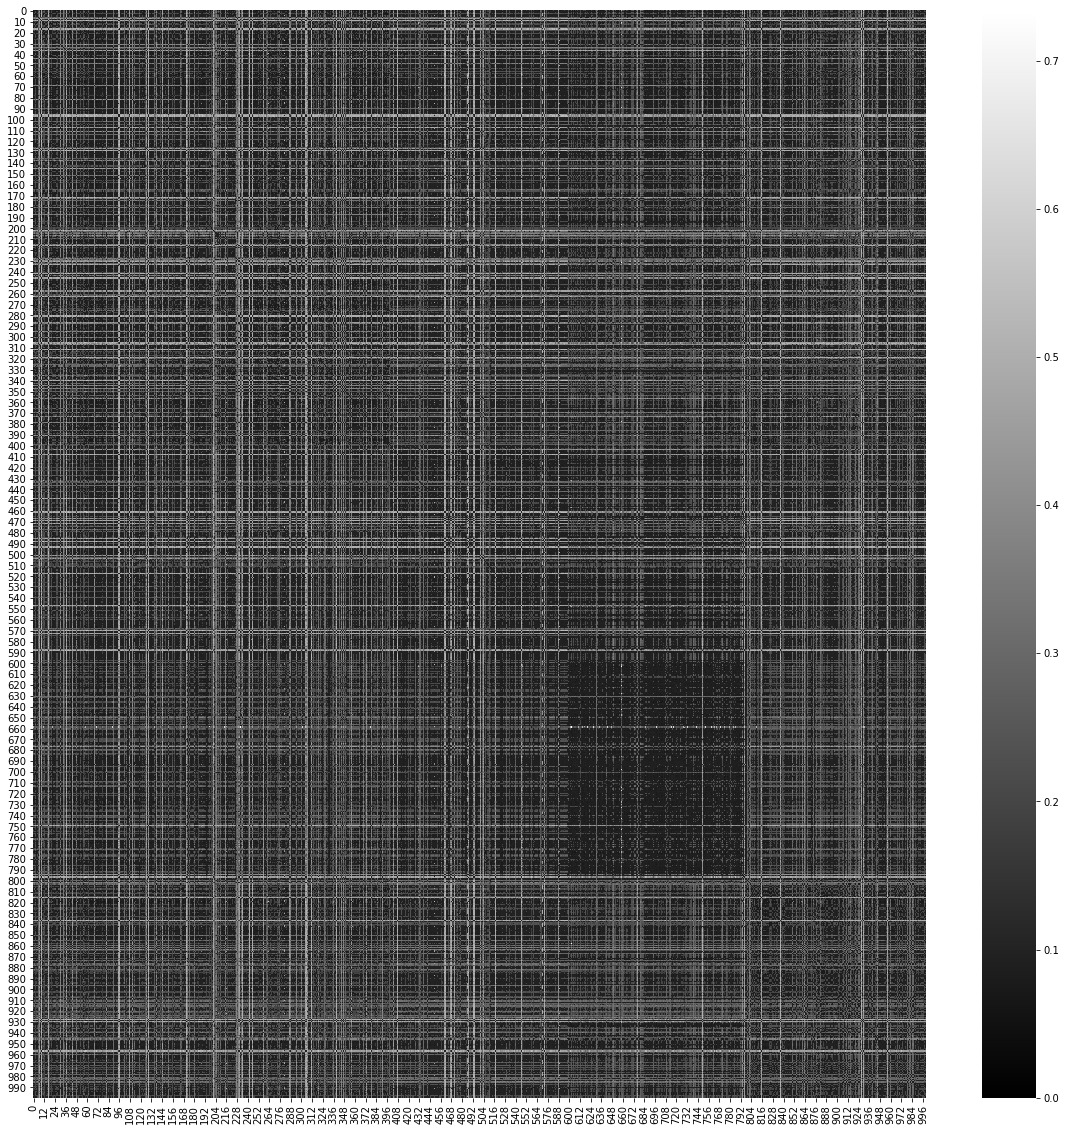

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(dist_matrix, cmap="gray")

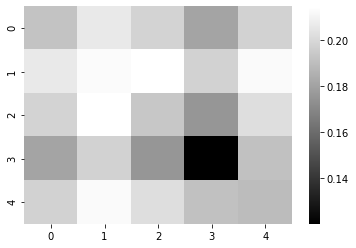

In [ ]:
dist_matrix2 = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        dist_matrix2[i,j] = np.mean(dist_matrix[i*n:(i+1)*n, j*n:(j+1)*n])

sns.heatmap(dist_matrix2, cmap="gray")

It is interesting to see that, although the other clases do not seem to follow a clear pattern, the class $3$ is isolated. This means that if our goal would be to isolate and identify such class, we could consider the barcode representation.

### Landscapes

The next step would be to provide something new for the Topological Data Analysis. Persistence Landscapes were first introduced in 2015 by Bubenik as an alternative representation to Barcodes and Persistence Diagrams. However, since they are piece-wise linear functions, they have many properties regarding its stadistics. 
Chazal et al. studied such properties and came with a new tool: the Average Landscape. The Average Landscape is a function that we want to estimate, given a set og landscapes from the same class.  We believe that this could be an interesting idea to give representatives of each class and help the clustering.

In [ ]:
persistence = [getPersistence(X.iloc[i].to_numpy(), num_points=100, clean=False) for i in tqdm(range(X.shape[0]))]
diag = [x[0] for x in persistence]

#### Confidence intervals

Since we are trying to estimate a function, we can give some confidence intervals. In the next cells, we give the Average landscape of each class and its confidence interval.

In [ ]:
nbld = 2 # number of Landscapes 
resolution = 1000
length_max = 1
length_min = 0
ld_dim = 0 # landscape dim

L = np.zeros((len(diag), resolution))

for i in tqdm(range(len(diag))):
  L[i,:] = np.array(landscapes_approx([x[1] for x in diag[i][1:]], length_min, length_max, resolution,nbld)[1])

In [ ]:
L_avgs = np.zeros((y.unique().shape[0], resolution))
for idx,i in enumerate(y.unique()):
  L_avgs[idx] = np.mean(L[y==i, :], axis=0)

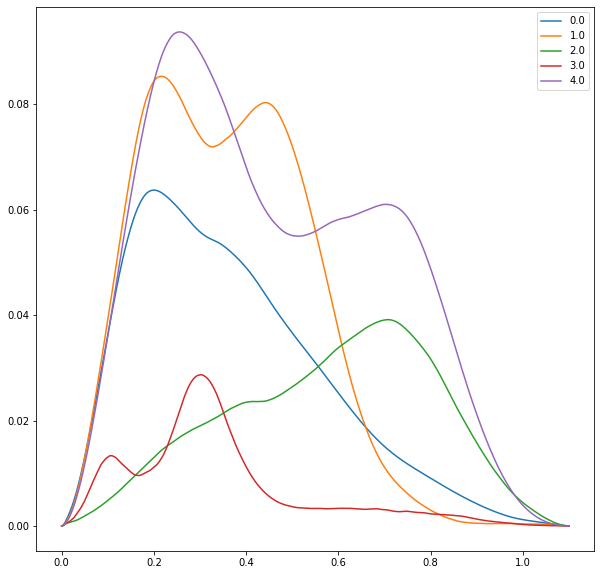

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(0,length_max * 1.1, num=resolution), L_avgs.T)
plt.legend(y.unique())
plt.show()

In [ ]:
lower = np.zeros((5,L_avgs.shape[1]))
upper = np.zeros((5,L_avgs.shape[1]))

for i in tqdm(range(5)):
  lower[i,:], upper[i,:] = confidence_interval(L_avgs[i,:], L[y==i,:], alpha=0.5)

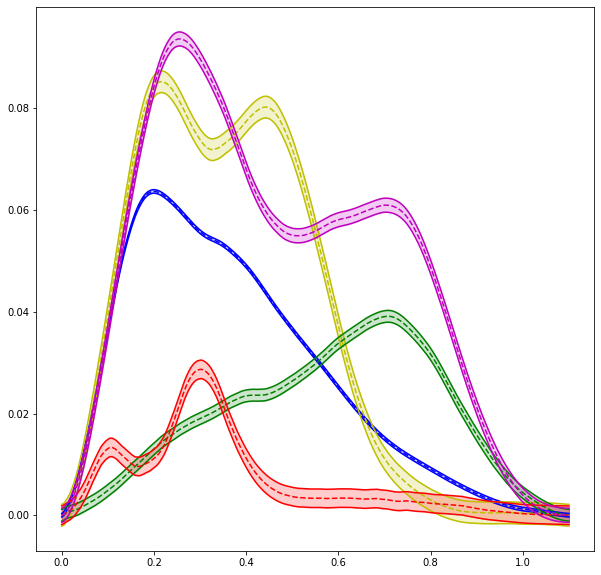

In [ ]:
plt.figure(figsize=(10,10))
colors = ['b', 'y', 'g', 'r', 'm']
for i in tqdm(range(5)):
  plt.fill_between(np.linspace(0,length_max * 1.1, num=resolution), lower[i,:], upper[i,:], color=colors[i], alpha=.2)
  plt.plot(np.linspace(0,length_max * 1.1, num=resolution), L_avgs[i,:], colors[i]+'--')
  plt.plot(np.linspace(0,length_max * 1.1, num=resolution), lower[i,:], colors[i])
  plt.plot(np.linspace(0,length_max * 1.1, num=resolution), upper[i,:], colors[i])
plt.show()

### Silhouette

Chazal et al. also discuss the possible representation thgour Silhouette. A Silhouette is a combination of all possible landscapes, to which we can assign different weights. It also has statistical properties. 

In [ ]:
from gudhi.representations import Silhouette

In [ ]:
resolution = 1000
p=0
sil = Silhouette(lambda x: np.abs(x[1]-x[0])**p, resolution=resolution)
pepe = sil.fit_transform([np.array([x[1] for x in diag[35][1:]])])

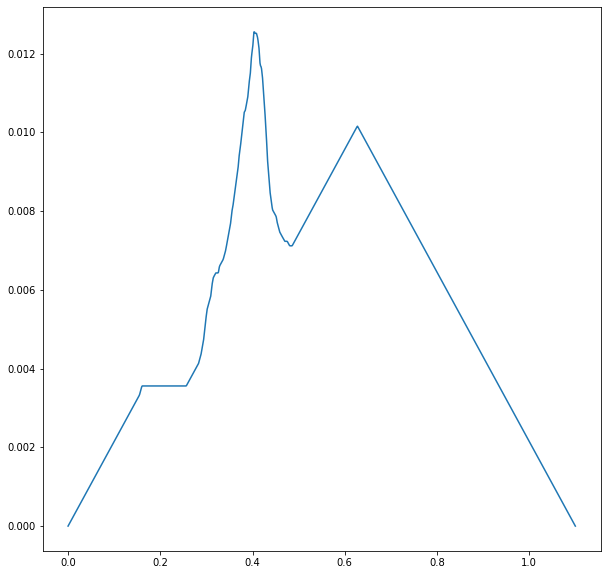

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(0,length_max * 1.1, num=resolution), pepe.T)
plt.show()

In [ ]:
resolution = 1000
length_max = 1
length_min = 0
ld_dim = 0 # landscape dim
p = 1

L = np.zeros((len(diag), resolution))

for i in tqdm(range(len(diag))):
  sil = Silhouette(lambda x: np.abs(x[1]-x[0])**p, resolution=resolution)
  L[i,:] = sil.fit_transform([np.array([x[1] for x in diag[i][1:]])])

In [ ]:
L_avgs = np.zeros((y.unique().shape[0], resolution))
for idx,i in enumerate(y.unique()):
  L_avgs[idx] = np.mean(L[y==i, :], axis=0)

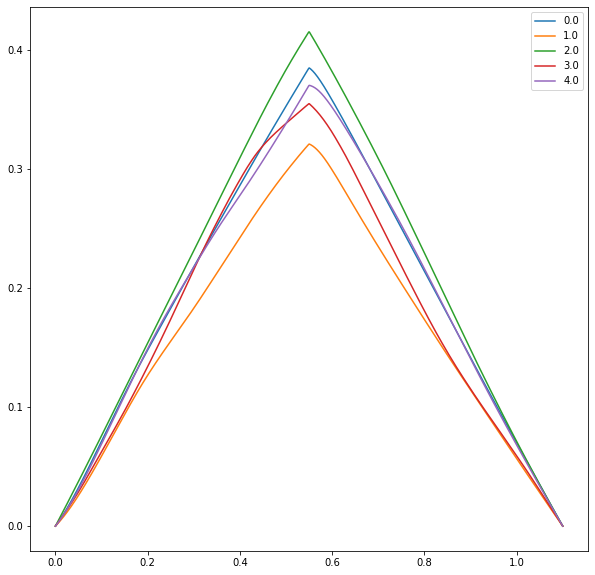

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(0,length_max * 1.1, num=resolution), L_avgs.T)
plt.legend(y.unique())
plt.show()

In [ ]:
lower = np.zeros((5,L_avgs.shape[1]))
upper = np.zeros((5,L_avgs.shape[1]))

for i in tqdm(range(5)):
  lower[i,:], upper[i,:] = confidence_interval(L_avgs[i,:], L[y==i,:], alpha=0.5)

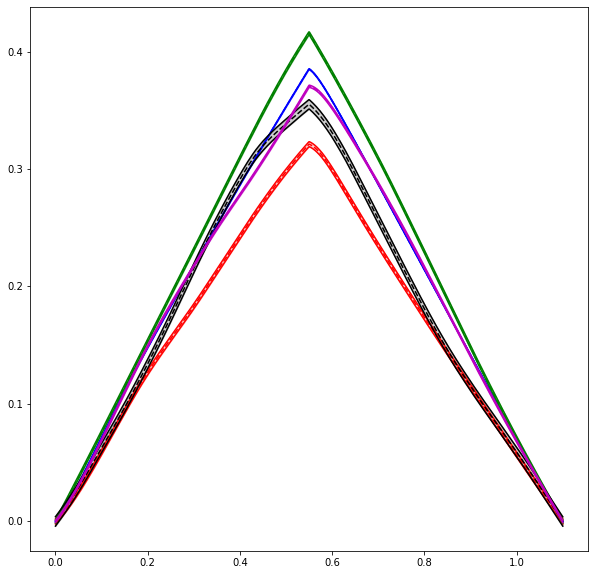

In [ ]:
plt.figure(figsize=(10,10))
colors = ['b', 'r', 'g', 'k', 'm']
for i in tqdm(range(5)):
  plt.fill_between(np.linspace(0,length_max * 1.1, num=resolution), lower[i,:], upper[i,:], color=colors[i], alpha=.2)
  plt.plot(np.linspace(0,length_max * 1.1, num=resolution), L_avgs[i,:], colors[i]+'--')
  plt.plot(np.linspace(0,length_max * 1.1, num=resolution), lower[i,:], colors[i])
  plt.plot(np.linspace(0,length_max * 1.1, num=resolution), upper[i,:], colors[i])
plt.show()